In [165]:
import logging
import sys

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

import cstrees.cstree as ct
import cstrees.stage as st

%load_ext autoreload
%autoreload 2
# logging.basicConfig(stream=sys.stderr, level=logging.ERROR)
logging.basicConfig(stream=sys.stderr, level=logging.CRITICAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
run icslearn.py

## Sachs Data Set

In [4]:
import random
import time

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq

import pandas as pd
import cstrees.scoring as sc
import cstrees.learning as ctl
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
sachs = pd.read_csv('sachs_observational.csv')

In [31]:
# Binarize data and add a row at the top of the dataframe containing variable cardinalities
sachsnp = sachs.to_numpy()

sachs2 = np.zeros([len(sachs), len(list(sachs.columns))], int)

for i in range(len(list(sachs.columns))):
    sachs2[:,i] = pd.cut(sachsnp[:,i], 2, labels = False)

# add row with state space cardinalities
sachs2states = np.zeros([len(sachs) + 1, len(list(sachs.columns))], int)
sachs2states[0,:] = [2 for i in range(len(list(sachs.columns)))]
for i in range(len(sachs)):
    sachs2states[i+1,:] = sachs2[i,:]

sachsdf = pd.DataFrame(sachs2states, columns = list(sachs.columns))

In [7]:
np.random.seed(1)
random.seed(1)
start = time.time()
score_table, context_scores, context_counts = sc.order_score_tables(sachsdf,
                                                                    max_cvars=2,
                                                                    alpha_tot=1.0,
                                                                    method="BDeu",
                                                                    poss_cvars=None)

orders, scores = ctl.gibbs_order_sampler(5000, score_table)
end = time.time()
print('Computation time in seconds:', end - start)

Gibbs order sampler: 100%|██████████| 5000/5000 [00:00<00:00, 15472.68it/s]

Computation time in seconds: 35.815650939941406


In [8]:
sachsmaporder = orders[scores.index(max(scores))]
print(sachsmaporder)

['Raf', 'PIP3', 'PLCg', 'PIP2', 'PKA', 'JNK', 'PKC', 'Akt', 'Erk', 'Mek', 'p38']


In [9]:
sachsopttree = ctl._optimal_cstree_given_order(sachsmaporder, context_scores)
sachsdftree = sachsopttree.to_df()

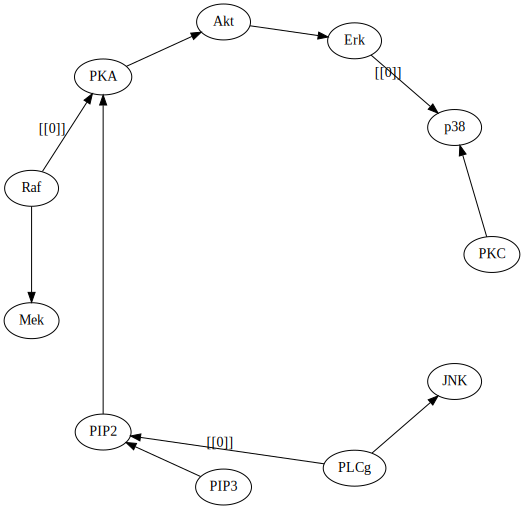

In [10]:
LDAG = sachsopttree.to_LDAG()
agraph = LDAG.plot_graphviz(args="-Goneblock=True",
                            prog="circo")
agraph

In [11]:
sachsreloaded = ct.df_to_cstree(sachsdftree)
sachsreloaded.estimate_stage_parameters(sachsdf)

In [26]:
# need interventional data...
sachs_i1 = pd.read_csv('2-sachs_Akt.csv')
sachs_i2 = pd.read_csv('3-sachs_PKC.csv')
sachs_i3 = pd.read_csv('4-sachs_PIP2.csv')
sachs_i4 = pd.read_csv('5-sachs_MEK.csv')
sachs_i5 = pd.read_csv('6-sachs_PIP3.csv')

In [32]:
# Binarize data and add a row at the top of the dataframe containing variable cardinalities
idatasets = [sachs_i1, sachs_i2, sachs_i3]
idiscdatasets =[]

for j in range(len(idatasets)):
    dataf = idatasets[j]

    sachsnp = dataf.to_numpy()

    sachs2 = np.zeros([len(dataf), len(list(dataf.columns))], int)

    for i in range(len(list(dataf.columns))):
        sachs2[:,i] = pd.cut(sachsnp[:,i], 2, labels = False)

    # add row with state space cardinalities
    sachs2states = np.zeros([len(dataf) + 1, len(list(dataf.columns))], int)
    sachs2states[0,:] = [2 for i in range(len(list(dataf.columns)))]
    for i in range(len(dataf)):
        sachs2states[i+1,:] = sachs2[i,:]

    sachsdfi = pd.DataFrame(sachs2states, columns = list(dataf.columns))

    icolumn = [5 + 1] + [j + 1 for k in range(sachsdfi.shape[0]-1)]
    sachsdfi.insert(0, "I", icolumn)
    sachsdfi = sachsdfi.drop([0])

    idiscdatasets += [sachsdfi]

In [33]:
idiscdatasets[1].head()

,I,Raf,Mek,PLCg,PIP2,PIP3,Erk,Akt,PKA,PKC,p38,JNK
1,2,0,1,1,1,0,1,0,0,1,1,0
2,2,0,0,1,0,0,1,1,1,1,1,1
3,2,1,1,1,1,0,1,1,0,1,1,0
4,2,0,0,1,1,0,1,1,0,1,1,1
5,2,0,0,0,0,0,1,1,1,1,1,1


In [34]:
icolumn = [5 + 1] + [0 for k in range(sachsdf.shape[0]-1)]
sachsdf.insert(0, "I", icolumn)
sachsdf.head()

,I,Raf,Mek,PLCg,PIP2,PIP3,Erk,Akt,PKA,PKC,p38,JNK
0,6,2,2,2,2,2,2,2,2,2,2,2
1,0,1,0,0,0,1,0,0,1,1,1,1
2,0,1,0,0,0,0,0,0,1,0,0,1
3,0,1,1,1,0,0,0,0,1,1,1,1
4,0,1,1,1,0,0,0,0,1,1,1,1


In [16]:
obs_plus_int = [sachsdf, idiscdatasets[0], idiscdatasets[1], idiscdatasets[2]]
sachsintdf = pd.concat(obs_plus_int)
print(sachsdf.shape[0])
print(sachsintdf.shape[0])

1756
4200


In [17]:
sachs_inttree = fit_itree(sachsreloaded, 3, sachsintdf)
print(sachs_inttree[1])

/Users/liamsolus/Dropbox/Research/alg-stat/graphical-models/CStrees/ICSlearn/.conda/lib/python3.11/site-packages/cstrees/cstree.py:421: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, dftmp])
/Users/liamsolus/Dropbox/Research/alg-stat/graphical-models/CStrees/ICSlearn/.conda/lib/python3.11/site-packages/cstrees/cstree.py:421: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, dftmp])
/Users/liamsolus/Dropbox/Research/alg-stat/graphical-models/CStrees/ICSlearn/.co

-19186.171319832778


In [18]:
for lev in range(sachs_inttree[0].p):
    print("level {}".format(lev))
    for s in sachs_inttree[0].stages[lev]:
        print(s.list_repr)

level 0
[0]
[1]
[2]
[3]
level 1
[{0, 2}, {0, 1}]
[1, {0, 1}]
[3, {0, 1}]
level 2
[{0, 2}, {0, 1}, {0, 1}]
[1, {0, 1}, {0, 1}]
[3, {0, 1}, {0, 1}]
level 3
[{0, 2}, {0, 1}, 0, {0, 1}]
[0, {0, 1}, 1, 0]
[{0, 1}, {0, 1}, 1, 1]
[1, {0, 1}, 0, {0, 1}]
[1, {0, 1}, 1, 0]
[2, {0, 1}, 1, 0]
[2, {0, 1}, 1, 1]
[3, {0, 1}, 0, {0, 1}]
[3, {0, 1}, 1, 0]
[3, {0, 1}, 1, 1]
level 4
[{0, 1, 3}, {0, 1}, {0, 1}, {0, 1}, 0]
[{0, 1, 3}, 0, {0, 1}, {0, 1}, 1]
[{0, 1, 3}, 1, {0, 1}, {0, 1}, 1]
[2, {0, 1}, {0, 1}, {0, 1}, 0]
[2, 0, {0, 1}, {0, 1}, 1]
[2, 1, {0, 1}, {0, 1}, 1]
level 5
[{0, 2, 3}, {0, 1}, {0, 1}, 0, {0, 1}, {0, 1}]
[{0, 3}, {0, 1}, {0, 1}, 1, {0, 1}, {0, 1}]
[1, {0, 1}, {0, 1}, 0, {0, 1}, {0, 1}]
[1, {0, 1}, {0, 1}, 1, {0, 1}, {0, 1}]
[2, {0, 1}, {0, 1}, 1, {0, 1}, {0, 1}]
level 6
[0, {0, 1}, {0, 1}, {0, 1}, {0, 1}, {0, 1}, {0, 1}]
[1, {0, 1}, {0, 1}, {0, 1}, {0, 1}, {0, 1}, {0, 1}]
[2, {0, 1}, {0, 1}, {0, 1}, {0, 1}, {0, 1}, {0, 1}]
[3, {0, 1}, {0, 1}, {0, 1}, {0, 1}, {0, 1}, {0, 1}]
level 7
[{0

## Produce interventional LDAG

collect the edges going from intervention nodes to the observational nodes they target (i.e. in which they change a stage)

In [19]:
newedges = get_i_edges(sachs_inttree[0])
for i in range(1, sachs_inttree[0].cards[0]):
    print('children of', i)
    print(newedges[i])

children of 1
[1, 2, 3, 5, 6, 7, 8, 9, 10]
children of 2
[3, 4, 5, 6, 7, 8, 9, 10]
children of 3
[1, 2, 3, 6, 7, 8, 9, 10]


collect the labels for the interventional edges.  I.e. the list of joint outcomes underwhich the interventional edge vanishes.  These joint outcomes encode the contexts of the stages that are invariant between the observational distribution and the interventional distribution for the intervention (the parent in the interventional edge).

In [20]:
newedgelabels = get_i_labels(sachs_inttree[0], newedges)

for L in newedgelabels.keys():
    print('intervention:', L)
    for level in newedgelabels[L].keys():
        print('level:', level)
        for x in newedgelabels[L][level]:
            print(x)

intervention: 1
level: 1
level: 2
level: 3
['*', 1, 1, '*', '*', '*', '*', '*', '*', '*', '*']
level: 5
level: 6
level: 7
['*', '*', '*', '*', 0, '*', '*', '*', '*', '*', '*']
level: 8
['*', '*', '*', '*', '*', '*', '*', 0, '*', '*', '*']
level: 9
level: 10
['*', '*', '*', '*', '*', '*', 1, '*', 0, '*', '*']
intervention: 2
level: 3
['*', 0, '*', '*', '*', '*', '*', '*', '*', '*', '*']
level: 4
level: 5
['*', '*', 0, '*', '*', '*', '*', '*', '*', '*', '*']
level: 6
level: 7
level: 8
level: 9
level: 10
['*', '*', '*', '*', '*', '*', 1, '*', 0, '*', '*']
['*', '*', '*', '*', '*', '*', 1, '*', 1, '*', '*']
intervention: 3
level: 1
level: 2
level: 3
level: 6
level: 7
level: 8
['*', '*', '*', '*', '*', '*', '*', 1, '*', '*', '*']
level: 9
[0, '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
level: 10
['*', '*', '*', '*', '*', '*', 1, '*', 1, '*', '*']


plot the interventional LDAG.  Since the labels for interventional edges are often very large, we omit the labels on the interventional edges.  

Instead, the function get_iLDAG returns a list, with the first element being a networkx representation of the interventional LDAG (with interventional edge labels omitted) and the second object is a dictionary with keys the interventional edges. When a value in this dictionary is empty the edge never vanishes.  

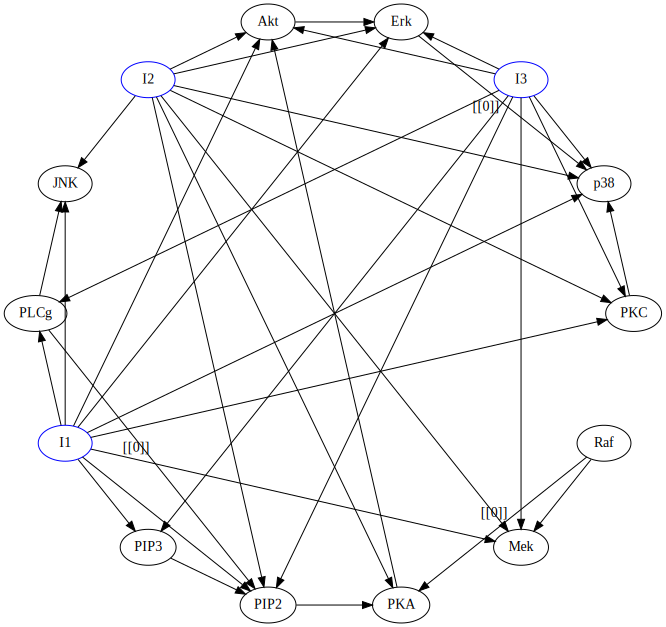

In [21]:
iLDAG = get_iLDAG(sachs_inttree[0], sachsopttree, icolor='blue')
iagraph = iLDAG[0].plot_graphviz(args="-Goneblock=True",
                            prog="circo")
iagraph

To see when the interventional edges vanish, we print the labels for the interventional edges.  for each edge these are the joint outcomes under which the interventional edge vanishes -- meaning that the stages for the child of this edge are invariant for the marginal context up to the child. 

In [46]:
print('variable order:')
print(sachsopttree.labels)
for edge in iLDAG[1].keys():
    print(edge)
    for label in iLDAG[1][edge]:
        print(label)


variable order:
['Raf', 'PIP3', 'PLCg', 'PIP2', 'PKA', 'JNK', 'PKC', 'Akt', 'Erk', 'Mek', 'p38']
('I1', 'PIP3')
('I1', 'PLCg')
('I1', 'PIP2')
['*', 1, 1, '*', '*', '*', '*', '*', '*', '*', '*']
('I1', 'JNK')
('I1', 'PKC')
('I1', 'Akt')
['*', '*', '*', '*', 0, '*', '*', '*', '*', '*', '*']
('I1', 'Erk')
['*', '*', '*', '*', '*', '*', '*', 0, '*', '*', '*']
('I1', 'Mek')
('I1', 'p38')
['*', '*', '*', '*', '*', '*', 1, '*', 0, '*', '*']
('I2', 'PIP2')
['*', 0, '*', '*', '*', '*', '*', '*', '*', '*', '*']
('I2', 'PKA')
('I2', 'JNK')
['*', '*', 0, '*', '*', '*', '*', '*', '*', '*', '*']
('I2', 'PKC')
('I2', 'Akt')
('I2', 'Erk')
('I2', 'Mek')
('I2', 'p38')
['*', '*', '*', '*', '*', '*', 1, '*', 0, '*', '*']
['*', '*', '*', '*', '*', '*', 1, '*', 1, '*', '*']
('I3', 'PIP3')
('I3', 'PLCg')
('I3', 'PIP2')
('I3', 'PKC')
('I3', 'Akt')
('I3', 'Erk')
['*', '*', '*', '*', '*', '*', '*', 1, '*', '*', '*']
('I3', 'Mek')
[0, '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
('I3', 'p38')
['*', '*', '*'

Second model produced for alternate choice of hyperparameters based on sensitivity analysis below.

In [208]:
sachs_inttree2 = fit_itree(sachsreloaded, 3, sachsintdf, alpha_tot=1e-27)

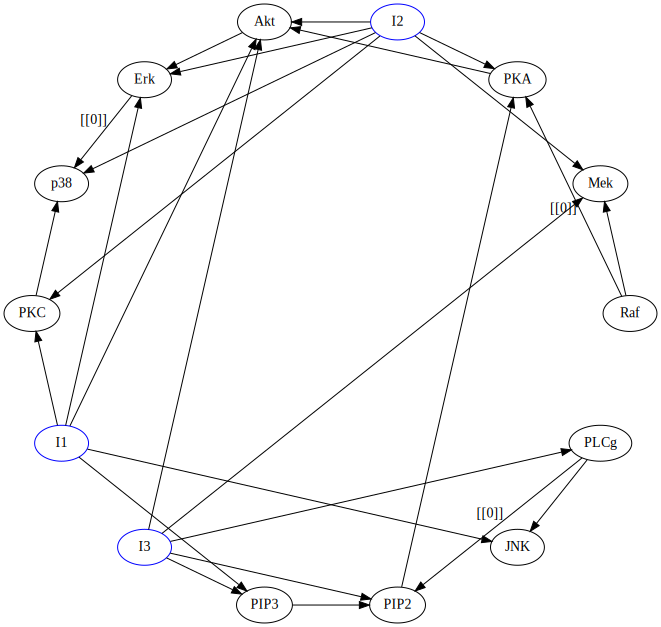

In [209]:
iLDAG2 = get_iLDAG(sachs_inttree2[0], sachsopttree, icolor='blue')
iagraph2 = iLDAG2[0].plot_graphviz(args="-Goneblock=True",
                            prog="circo")
iagraph2

In [210]:
print('variable order:')
print(sachsopttree.labels)
for edge in iLDAG2[1].keys():
    print(edge)
    for label in iLDAG2[1][edge]:
        print(label)

variable order:
['Raf', 'PIP3', 'PLCg', 'PIP2', 'PKA', 'JNK', 'PKC', 'Akt', 'Erk', 'Mek', 'p38']
('I1', 'PIP3')
('I1', 'JNK')
('I1', 'PKC')
('I1', 'Akt')
['*', '*', '*', '*', 0, '*', '*', '*', '*', '*', '*']
('I1', 'Erk')
['*', '*', '*', '*', '*', '*', '*', 1, '*', '*', '*']
('I2', 'PKA')
('I2', 'PKC')
('I2', 'Akt')
('I2', 'Erk')
['*', '*', '*', '*', '*', '*', '*', 0, '*', '*', '*']
('I2', 'Mek')
[0, '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
('I2', 'p38')
['*', '*', '*', '*', '*', '*', 1, '*', 0, '*', '*']
['*', '*', '*', '*', '*', '*', 1, '*', 1, '*', '*']
('I3', 'PIP3')
('I3', 'PLCg')
('I3', 'PIP2')
('I3', 'Akt')
('I3', 'Mek')
[0, '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


### Hyperparameter Ablation

The BDeu and CS-BDeu scores are Bayesian scores known to be senstive to the choice of hyperparameters. To get a sense of the sensitivty of iCSlearn to the choice of hyperparameters, we ran iCSlearn on the data set for varying choices of alpha_tot and recorded the number of interventional edges in the resulting interventional LDAGs. 

In [168]:
alpha_list = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 1e-1, 1e-2, 1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,
              1e-14,1e-15,1e-16,1e-17,1e-18,1e-19,1e-20,1e-21,1e-22,1e-23,1e-24,1e-25,
              1e-26,1e-27,1e-28,1e-29,1e-30]

In [169]:
ablation_results = []

In [170]:
for a in alpha_list:
    sachs_inttree_alpha = fit_itree(sachsreloaded, 3, sachsintdf, alpha_tot=a)
    iLDAG_alpha = get_iLDAG(sachs_inttree_alpha[0], sachsopttree, icolor='blue')
    result = []
    result += [a]
    result += [len(iLDAG_alpha[1].keys())]
    if ('I1', 'Akt') in iLDAG_alpha[1] and ('I2', 'PKC') in iLDAG_alpha[1] and ('I3', 'PIP2') in iLDAG_alpha[1]:
        result += [1]
    else:
        result += [0]
    ablation_results += [result]

In [171]:
for res in ablation_results:
    print(res)

[10, 28, 1]
[9, 28, 1]
[8, 28, 1]
[7, 28, 1]
[6, 28, 1]
[5, 28, 1]
[4, 27, 1]
[3, 26, 1]
[2, 26, 1]
[1, 25, 1]
[0.1, 25, 1]
[0.01, 25, 1]
[0.001, 25, 1]
[0.0001, 22, 1]
[1e-05, 22, 1]
[1e-06, 21, 1]
[1e-07, 21, 1]
[1e-08, 21, 1]
[1e-09, 21, 1]
[1e-10, 20, 1]
[1e-11, 19, 1]
[1e-12, 18, 1]
[1e-13, 18, 1]
[1e-14, 18, 1]
[1e-15, 18, 1]
[1e-16, 17, 1]
[1e-17, 17, 1]
[1e-18, 17, 1]
[1e-19, 17, 1]
[1e-20, 17, 1]
[1e-21, 17, 1]
[1e-22, 17, 1]
[1e-23, 16, 1]
[1e-24, 16, 1]
[1e-25, 16, 1]
[1e-26, 16, 1]
[1e-27, 16, 1]
[1e-28, 14, 0]
[1e-29, 13, 0]
[1e-30, 13, 0]


In [181]:
abl_results = []
for r in ablation_results:
    if r[2]== 1:
        abl_results += [[r[0],r[1],'yes']]
    else:
        abl_results += [[r[0],r[1],'no']]

In [182]:
ablation_df = pd.DataFrame(abl_results, columns=['alpha total', 'number interventional edges', 'accepted edges present'])

In [183]:
ablation_df.head()

,alpha total,number interventional edges,accepted edges present
0,10.0,28,yes
1,9.0,28,yes
2,8.0,28,yes
3,7.0,28,yes
4,6.0,28,yes


In [175]:
import seaborn as sns

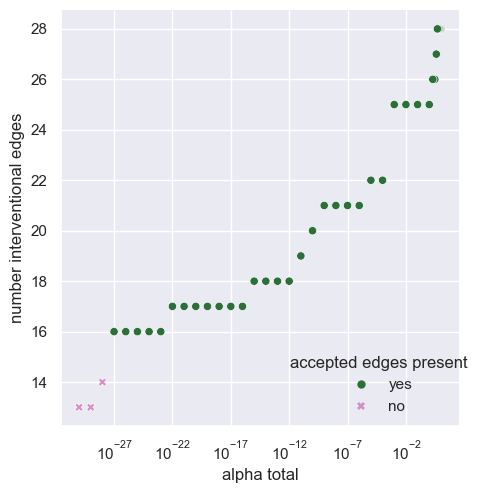

In [218]:

abl = sns.relplot(data=ablation_df, x="alpha total", y="number interventional edges", hue="accepted edges present", style="accepted edges present", hue_order=['yes','no'], palette='cubehelix')
abl.set(xscale='log')
sns.set_style("darkgrid")
sns.move_legend(abl, "upper left", bbox_to_anchor=(0.45, 0.3))
plt.show()
